In [1]:
import numpy as np
import skimage
from scipy.ndimage import filters 
import matplotlib
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import math
import time

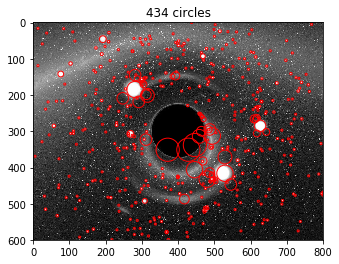

0.16968178749084473 sec elapsed


In [4]:
def increasing_filter_size(img, initial, levels, k):
    scale_space = np.empty((img.shape[0], img.shape[1], levels))
    scale = initial
    for i in range(levels):
        scale_space[:,:,i] = (scale**2 * filters.gaussian_laplace(img, scale, mode = 'constant')) ** 2
        scale *= k
    return scale_space

def downsample_image(img, initial, levels, k):
    shape = img.shape
    scale_space = np.empty((img.shape[0], img.shape[1], levels))
    scaled_image = img
    for i in range(levels):
        scale_space[:,:,i] = cv2.resize((initial**2 * filters.gaussian_laplace(scaled_image, initial, mode = 'constant')) ** 2, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)
        scaled_image = cv2.resize(scaled_image, (int(scaled_image.shape[1] / k) , int(scaled_image.shape[0] / k)), interpolation = cv2.INTER_CUBIC)
    return scale_space

def downsample_dog(img, initial, levels, k):
    shape = img.shape
    scaled_image = img
    scale_space = np.empty((img.shape[0], img.shape[1], levels))
    pyramid = []
    for i in range(levels + 1):
        pyramid.append(filters.gaussian_filter(scaled_image,initial))
        scaled_image = cv2.resize(scaled_image, (int(scaled_image.shape[1] / k) , int(scaled_image.shape[0] / k)), interpolation = cv2.INTER_CUBIC)
    scaled_pyramid = []
    for i in range(levels + 1):
        scaled_pyramid.append(cv2.resize(pyramid[i], (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC))
    for i in range(levels):
        scale_space[:,:,i] = (initial**2 *(scaled_pyramid[i + 1] - scaled_pyramid[i]))**2
    return scale_space

def nms_2d(space, s):
    return filters.rank_filter(space, -1, size = (s, s))

def nms_3d(nms_2d_space, scale_space, levels):
    nms_3d_space = np.copy(nms_2d_space)
    nms_3d_space = filters.rank_filter(nms_2d_space, -1, size = (1,1,3))
    mask = (scale_space != nms_3d_space)
    nms_3d_space[mask] = 0
    return nms_3d_space
    
def extract(space, threshold):
    vec_x, vec_y, levels = np.where(space > threshold)
    return vec_x, vec_y, levels


def radius_of_level(levels, multiplier):
    return math.sqrt(2) * 2 * multiplier ** levels
        
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()
    
from scipy import signal
    

def harris_response(image):
    y, x = mgrid[-3:4, -3:4]
    gx = - x * exp(-(x**2/float((0.5*3)**2)+y**2/float((0.5*3)**2))) 
    gy = - y * exp(-(x**2/float((0.5*3)**2)+y**2/float((0.5*3)**2))) 
    imx = signal.convolve(image,gx, mode='same')
    imy = signal.convolve(image,gy, mode='same')
    g = exp(-(x**2/float(3)+y**2/float(3)))
    gauss = g/g.sum()
    Wxx = signal.convolve(imx*imx,gauss, mode='same')
    Wxy = signal.convolve(imx*imy,gauss, mode='same')
    Wyy = signal.convolve(imy*imy,gauss, mode='same')

    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    return Wdet / Wtr

def pipeline(img, option = 'downsample', num_levels = 15, sigma = 2, scale_multiplier = math.sqrt(math.sqrt(2)), harris = False):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) / 255
    tic = time.time()
    if option == 'increasing':
        space = increasing_filter_size(gray, sigma, num_levels, scale_multiplier)
    elif option == 'downsample':
        space = downsample_image(gray, sigma, num_levels, scale_multiplier)
    elif option == 'dog':
        space = downsample_dog(gray, sigma, num_levels, scale_multiplier)
#     for i in range(num_levels):
#         plt.imshow(space[:,:,i], cmap='gray')
#         plt.show()
    toc = time.time()
    nms_2d_space = np.empty((gray.shape[0], gray.shape[1], num_levels))
    for i in range(num_levels):
        nms_2d_space[:,:,i] = nms_2d(space[:,:,i], int(3 * scale_multiplier**(i)) )
    nms_3d_space = nms_3d(nms_2d_space, space,num_levels)
    if harris is True:
        mask = harris_response(gray) < 0.06
        nms_3d_space[mask,0:3]=0
    cx, cy, levels = extract(nms_3d_space, 0.01)
    show_all_circles(gray, cy, cx, radius_of_level(levels, scale_multiplier))
    print(toc-tic, 'sec elapsed')


    
import glob

images = glob.glob('assignment2_images/universe.jpg')
for fname in images:
    img = cv2.imread(fname)
    # default setting, downsample method.
#     pipeline(img)
    # next line is for dog result
    pipeline(img, option = 'dog', num_levels = 15, sigma = 2, scale_multiplier = math.sqrt(math.sqrt(2)), harris = False)
    # next line is for harris response result
    #pipeline(img, option = 'downsample', num_levels = 15, sigma = 2, scale_multiplier = math.sqrt(math.sqrt(2)), harris = True)